# Symptom Extraction and Linking from Vaccine Adverse Event Reports
### author: Matthew Hullstrung

### Import packages

In [12]:
!pip install stanza
!pip install fuzzywuzzy
!pip install levenshtein

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [13]:
import stanza
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


stanza.download('en', package='i2b2')

2023-12-11 22:38:05 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package |
-----------------------------
| ner             | i2b2    |
| backward_charlm | mimic   |
| forward_charlm  | mimic   |
| pretrain        | mimic   |

INFO:stanza:Downloading these customized packages for language: en (English)...
| Processor       | Package |
-----------------------------
| ner             | i2b2    |
| backward_charlm | mimic   |
| forward_charlm  | mimic   |
| pretrain        | mimic   |

2023-12-11 22:38:05 INFO: File exists: /home/matt/stanza_resources/en/ner/i2b2.pt
INFO:stanza:File exists: /home/matt/stanza_resources/en/ner/i2b2.pt
2023-12-11 22:38:05 INFO: File exists: /home/matt/stanza_resources/en/backward_charlm/mimic.pt
INFO:stanza:File exists: /home/matt/stanza_resources/en/backward_charlm/mimic.pt
2023-12-11 22:38:05 INFO: File exists: /home/matt/stanza_resources/en/forward_charlm/mimic.pt
INFO:stanza:File exists: /home/matt/stanza_r

### Load and Filter the Data

We only want 10,000 samples from the 2022 COVID-19 Vaccine VAERS reports. We must first load the data for all vaccines then filter the dataset for COVID-19 vaccine reports.

In [14]:
# Load the VAERS DATA, VAERS Symptoms, and VAERS Vaccine datasets
data = pd.read_csv('data/2022VAERSDATA.csv', usecols=['VAERS_ID', 'SYMPTOM_TEXT'], encoding='latin1',)
symptoms = pd.read_csv('data/2022VAERSSYMPTOMS.csv', encoding='latin1')
vaccine = pd.read_csv('data/2022VAERSVAX.csv', encoding='latin1')

# Merge the VAERS DATA and VAERS Symptoms datasets based on VAERS_ID
merged_data = data.merge(symptoms, on='VAERS_ID', how='left')

# Merge the merged data and VAERS Vaccine datasets based on VAERS_ID
merged_data = merged_data.merge(vaccine, on='VAERS_ID', how='left')

# Filter the dataset for COVID-19 vaccine reports
covid_vaccine_data = merged_data[merged_data['VAX_TYPE'] == 'COVID19']

# Filter to only include valid reports with reasonable lengths
def filter_reasonable_length(report):
    if pd.isna(report):
        return False
    return len(report) <= 3000 and len(report) >= 50

covid_vaccine_data = covid_vaccine_data[covid_vaccine_data['SYMPTOM_TEXT'].apply(filter_reasonable_length)]

# Use only 10,000 samples from the dataset
covid_vaccine_data = covid_vaccine_data.sample(n=10000, random_state=10)

print(f'Number of samples: {len(covid_vaccine_data)}')

Number of samples: 10000


### Data Preprocessing and Analysis

We will perform some statistical analysis of our data. This will include getting the distribution of the number of different symptoms related to COVID-19 vaccines as well as getting the distribution of the length of the different reports.

We'll begin by looking at the distribution of the counts of COVID-19 related standard symptoms.

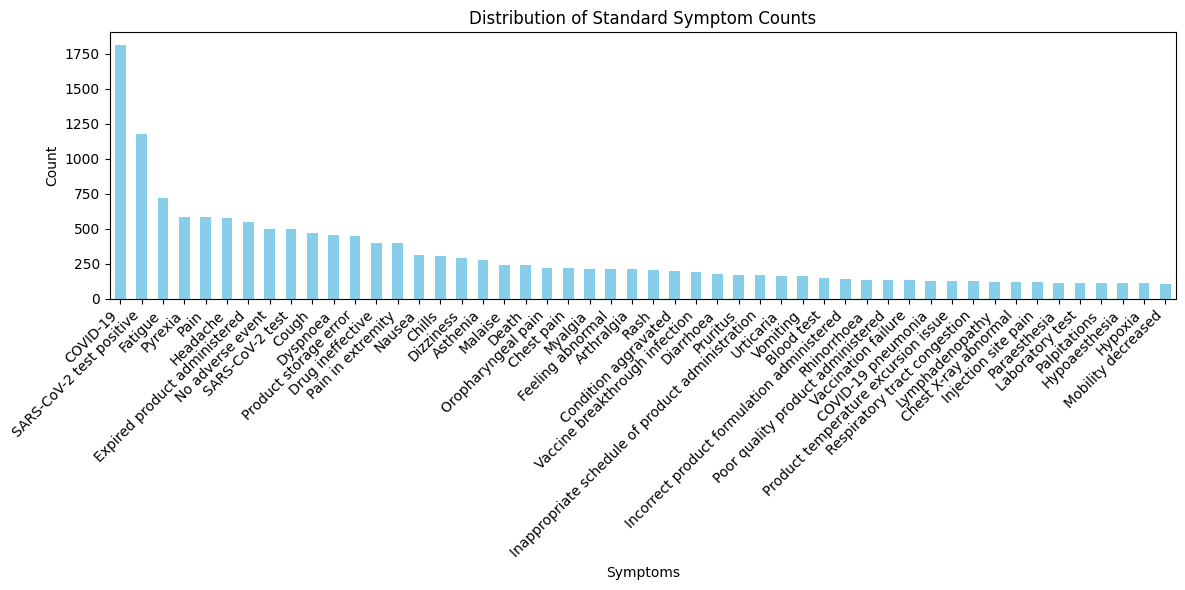

In [15]:
# Extract symptoms from columns SYMPTOM1 to SYMPTOM5
symptoms_columns = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']
all_symptoms = covid_vaccine_data[symptoms_columns].stack()

# Get the most common symptoms (top 100 most occurring standard symptoms)
most_common_symptoms = all_symptoms.value_counts().head(100)

# Get the top 50 standard symptoms (top 100 is too many to plot nicely)
top_50_symptoms = all_symptoms.value_counts().head(50)

# Plot the distribution of symptoms
plt.figure(figsize=(12, 6))
top_50_symptoms.plot(kind='bar', color='skyblue')
plt.title('Distribution of Standard Symptom Counts')
plt.xlabel('Symptoms')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

Now let's analyze the distribution of the report lengths.

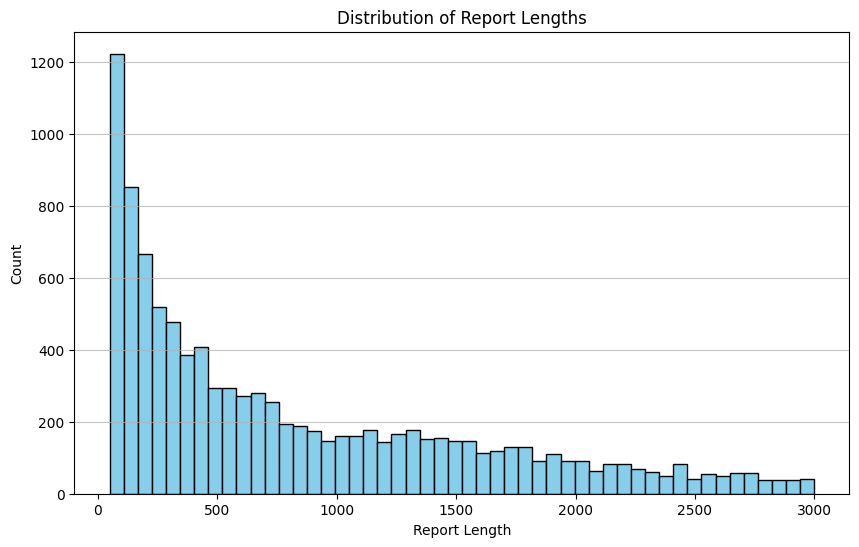

Number of Missing Reports:
0

Numerical Statistics of the Report Lengths:
count    10000.000000
mean       825.472900
std        750.276735
min         50.000000
25%        202.000000
50%        555.000000
75%       1307.000000
max       2999.000000
Name: SYMPTOM_TEXT, dtype: float64


In [16]:
# Calculate the length of each report
report_lengths = covid_vaccine_data['SYMPTOM_TEXT'].str.len()

# Plot the distribution of report lengths
plt.figure(figsize=(10, 6))
report_lengths.plot(kind='hist', bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Report Lengths')
plt.xlabel('Report Length')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='-', alpha=0.7)

# Show the plot
plt.show()

print("Number of Missing Reports:")
print(report_lengths.isnull().sum())

print("\nNumerical Statistics of the Report Lengths:")
print(report_lengths.describe())

Now, we will create a vocabulary of our data. This will be a sorted list of unique standard symptoms.

In [17]:
# Extract standard symptoms from the COVID-19 vaccine data
standard_symptoms_columns = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']
all_standard_symptoms = covid_vaccine_data[standard_symptoms_columns].stack().tolist()

# Create a vocabulary (unique standard symptoms)
standard_symptoms = sorted(list(set(all_standard_symptoms)))

## Extracting Symptom-related Entities

### Initialize Stanza Package and Create Pipeline

The i2b2 package will help find entities related to PROBLEM, TEST, and TREATMENT, with PROBLEM entities being symptoms.

In [18]:
# Download biomedical/clinical models
stanza.download('en', package='mimic', processors={'ner': 'i2b2'})

# Create the Stanza pipeline
ner = stanza.Pipeline('en', package='mimic', processors={'ner': 'i2b2'})

2023-12-11 22:38:12 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package        |
------------------------------------
| tokenize        | mimic          |
| pos             | mimic_charlm   |
| lemma           | mimic_nocharlm |
| depparse        | mimic_charlm   |
| ner             | i2b2           |
| backward_charlm | mimic          |
| forward_charlm  | mimic          |
| pretrain        | mimic          |

INFO:stanza:Downloading these customized packages for language: en (English)...
| Processor       | Package        |
------------------------------------
| tokenize        | mimic          |
| pos             | mimic_charlm   |
| lemma           | mimic_nocharlm |
| depparse        | mimic_charlm   |
| ner             | i2b2           |
| backward_charlm | mimic          |
| forward_charlm  | mimic          |
| pretrain        | mimic          |

2023-12-11 22:38:12 INFO: File exists: /home/matt/stanza_resources/en/tokenize/mimic

2023-12-11 22:38:14 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | mimic          |
| pos       | mimic_charlm   |
| lemma     | mimic_nocharlm |
| depparse  | mimic_charlm   |
| ner       | i2b2           |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | mimic          |
| pos       | mimic_charlm   |
| lemma     | mimic_nocharlm |
| depparse  | mimic_charlm   |
| ner       | i2b2           |

2023-12-11 22:38:14 INFO: Using device: cuda
INFO:stanza:Using device: cuda
2023-12-11 22:38:14 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2023-12-11 22:38:14 INFO: Loading: pos
INFO:stanza:Loading: pos
2023-12-11 22:38:14 INFO: Loading: lemma
INFO:stanza:Loading: lemma
2023-12-11 22:38:14 INFO: Loading: depparse
INFO:stanza:Loading: depparse
2023-12-11 22:38:14 INFO: Loading: ner
INFO:stanza:Loading: ner
2023-12-

### Extract Symptom-related Entities

We will use the stanza package to help extract symptoms. We will input the descriptions of the vaccine adverse events (symptom texts) and output a list of symptom related entities. Again, PROBLEM entities are symptoms.

In [19]:
from tqdm import tqdm

# For progress_apply (to show progress of extraction)
tqdm.pandas()

# Extract symptom entities by performing NER
def extract_symptom_entities(text):
    doc = ner(text)
    entities = set()
    for ent in doc.ents:
        # We consider symptoms as entities labeled 'PROBLEM'
        if ent.type == 'PROBLEM':
            entities.add(ent.text)
    return entities

# Apply the function to each row in the 'SYMPTOM_TEXT' column
symptom_entities = covid_vaccine_data['SYMPTOM_TEXT'].progress_apply(extract_symptom_entities)

print()
print(symptom_entities)


100%|██████████| 10000/10000 [28:55<00:00,  5.76it/s]


264911                                     {ADVERSE EFFECT}
44024     {Normal flu-like symptoms, a SHARP drop, fatigue}
188919    {DIPLOPIA, Concomitant Products, DIPLOPIA (Dou...
356209    {low thyroid", glaucoma, Known allergies, UTI,...
256890    {bulging disc on left, positive, shortness of ...
                                ...                        
16115     {very dizzy, DIZZINESS, NAUSEA, nausea, Nausea...
170405    {headache, the headache, fever, a headache, fa...
93382     {a UTI, pain in my leg/groin area, my enlarged...
295327    {covid-19 infection, COVID-19 INFECTION, the v...
163050    {hot and cold, stiffness, severe shortness of ...
Name: SYMPTOM_TEXT, Length: 10000, dtype: object


## Link Entities to Standard Symptoms

Use fuzzy matching to link entities to standard symptoms. If there is not a match, check the fuzzy matching score with synonyms of the entity. This combats issues such as 'fever' being considered 'pyrexia' in the standard symptom list.

In [20]:
from fuzzywuzzy import process
from nltk.corpus import wordnet
from tqdm import tqdm

import nltk
nltk.download('wordnet')

def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return set(synonyms)

def fuzzy_match_symptoms(entities, standard_symptoms):
    linked_symptoms = [{} for _ in range(len(entities))]
    threshold = 90  # Fuzzy matching threshold

    for i, entity_list in enumerate(tqdm(entities, desc="Processing Entities", unit="entity")):
        for entity in entity_list:
            # Use fuzzywuzzy to find the best match
            match, score = process.extractOne(entity, standard_symptoms)

            # If no good match, try matching synonyms
            if score < threshold:
                synonyms = get_synonyms(entity)
                for synonym in synonyms:
                    synonym_match, synonym_score = process.extractOne(synonym, standard_symptoms)
                    if synonym_score > score:
                        match, score = synonym_match, synonym_score

            # If the fuzzy score is above the threshold, it is a match
            if score >= threshold:
                if entity not in linked_symptoms:
                    linked_symptoms[i][entity] = match
                else:
                    # If multiple potential matches, choose the one with the highest score
                    current_score = process.extractOne(linked_symptoms[entity], [entity])[1]
                    if score > current_score:
                        linked_symptoms[i][entity] = match

        if not linked_symptoms[i]:
            linked_symptoms[i]['No adverse event'] = 'No adverse event'

    return linked_symptoms

[nltk_data] Downloading package wordnet to /home/matt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Define our inputs:
1. symptom_entities: The extracted entities
2. vocab_1: List of all standard symptoms
3. vocab_2: List of the top 100 most common symptoms 

In [21]:
# Inputs
symptom_entities
vocab_1 = standard_symptoms # all standard symptoms
vocab_2 = list(most_common_symptoms.index) # top 100 most common symptoms

Perform fuzzy matching on all standard symptoms.

In [22]:
# Apply fuzzy matching for each set of symptoms
linked_symptoms = fuzzy_match_symptoms(symptom_entities, vocab_1) # match on all standard symptoms

# Display the first 25 linked symptoms
for i, item in enumerate(linked_symptoms[:25]):
    print(f'Report {i + 1}:')
    for entity, linked_symptom in item.items():
        if linked_symptom:
            print(f"    {entity} -> {linked_symptom}")
        else:
            print(f"    {entity} -> No valid match found")

Processing Entities: 100%|██████████| 10000/10000 [2:20:51<00:00,  1.18entity/s] 

Report 1:
    No adverse event -> No adverse event
Report 2:
    fatigue -> Fatigue
Report 3:
    DIPLOPIA -> Diplopia
    DIPLOPIA (Double vision) outcome -> Diplopia
Report 4:
    glaucoma -> Glaucoma
    UTI -> Therapeutic procedure
Report 5:
    positive -> Allergy test positive
    congestion -> Ear congestion
    pain -> Pain
    severe left leg pain -> Pain
    her leg pain -> Pain
    sleep -> Obstructive sleep apnoea syndrome
    breast cancer -> Breast cancer female
    sciatic pain -> Pain
Report 6:
    adverse reaction -> Adverse reaction
Report 7:
    severe obesity -> Obesity
    HTN -> Muscle tightness
    low oxygen saturation -> Oxygen saturation
    OSA -> Adiposis dolorosa
    symptoms -> Lower urinary tract symptoms
    acute hypoxemic respiratory failure -> Acute respiratory failure
    Covid pneumonia -> COVID-19 pneumonia
    diarrhea -> Diarrhoea
    covid pneumonia -> COVID-19 pneumonia
    cough -> Cough
Report 8:
    vomitting -> Vomiting
    chills -> Chills

Perform fuzzy matching on the top 100 most common symptoms.

In [23]:
# fuzzy match on top 100 most common symptoms
common_linked_symptoms = fuzzy_match_symptoms(symptom_entities, vocab_2)

# Display the first 25 (most common) linked symptoms
for i, item in enumerate(common_linked_symptoms[:25]):
    print(f'Report {i + 1}:')
    for entity, linked_symptom in item.items():
        if linked_symptom:
            print(f"    {entity} -> {linked_symptom}")
        else:
            print(f"    {entity} -> No valid match found")

Processing Entities: 100%|██████████| 10000/10000 [06:05<00:00, 27.37entity/s]

Report 1:
    No adverse event -> No adverse event
Report 2:
    fatigue -> Fatigue
Report 3:
    No adverse event -> No adverse event
Report 4:
    No adverse event -> No adverse event
Report 5:
    positive -> SARS-CoV-2 test positive
    congestion -> Respiratory tract congestion
    pain -> Pain
    severe left leg pain -> Pain
    her leg pain -> Pain
    sciatic pain -> Pain
Report 6:
    No adverse event -> No adverse event
Report 7:
    acute hypoxemic respiratory failure -> Acute respiratory failure
    Covid pneumonia -> COVID-19 pneumonia
    diarrhea -> Diarrhoea
    covid pneumonia -> COVID-19 pneumonia
    cough -> Cough
Report 8:
    vomitting -> Vomiting
    chills -> Chills
    excruciating pain -> Pain
    tiredness -> Fatigue
Report 9:
    No adverse event -> No adverse event
Report 10:
    Chronic pain -> Pain
Report 11:
    No adverse event -> No adverse event
Report 12:
    No adverse event -> No adverse event
Report 13:
    a rash -> Rash
Report 14:
    pain in k

## Automatic Evaluation

Automatic evaluation will be performed using precision and recall. However, do note that these may be very inaccurate due to the integrity of the so-called ground truth annotations. I use the standard symptom set (up to 5 standard symptoms) for each report as the ground truth, but in many cases, this set does not include all of the symptoms. Other times, it will include symptoms that are unexplained in the symptom text, making them virtually impossible to extract from the symptom text alone.

Calculate precision and recall for linked symptoms based on all symptoms (vocab 1).

In [ ]:
# VOCAB 1 AUTOMATIC EVALUATION

# Get ground truth as the standard symptoms per report
ground_truth = covid_vaccine_data[['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']]

# Counters for true positives, false positives, and false negatives
true_positives = 0
false_positives = 0
false_negatives = 0

# Threshold to account for misspellings in ground truth
threshold = 90

# Compute precision and recall
for i, item in enumerate(linked_symptoms):
    # Initialize sets for true positives and expected symptoms in the current report
    true_positives_in_report = set()
    expected_symptoms_in_report = set(item.values())

    for entity, expected_linked_symptom in item.items():
        # Use fuzzywuzzy to find the best match in the ground truth (account for misspellings)
        match, score = process.extractOne(expected_linked_symptom, ground_truth.iloc[i].dropna().values)

        # Consider a match only if the score is above the threshold
        if score >= threshold:
            true_positives_in_report.add(expected_linked_symptom)
            true_positives += 1
        else:
            false_positives += 1

    # Calculate false negatives for the current report
    false_negatives += len(expected_symptoms_in_report - true_positives_in_report)

# Calculate precision and recall
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0

print(f"Precision (all symptoms): {precision:.2%}")
print(f"Recall (all symptoms): {recall:.2%}")

Precision (all symptoms): 34.84%
Recall (all symptoms): 37.54%


Calculate precision and recall for linked symptoms based on most common symptoms (vocab 2).

In [27]:
# VOCAB 2 AUTOMATIC EVALUATION

# Counters for true positives, false positives, and false negatives
true_positives = 0
false_positives = 0
false_negatives = 0

# Threshold to account for misspellings in ground truth
threshold = 90

# Compute precision and recall
for i, item in enumerate(common_linked_symptoms):
    # Initialize sets for true positives and expected symptoms in the current report
    true_positives_in_report = set()
    expected_symptoms_in_report = set(item.values())

    for entity, expected_linked_symptom in item.items():
        # Use fuzzywuzzy to find the best match in the ground truth (account for misspellings)
        match, score = process.extractOne(expected_linked_symptom, ground_truth.iloc[i].dropna().values)

        # Consider a match only if the score is above the threshold
        if score >= threshold:
            true_positives_in_report.add(expected_linked_symptom)
            true_positives += 1
        else:
            false_positives += 1

    # Calculate false negatives for the current report
    false_negatives += len(expected_symptoms_in_report - true_positives_in_report)

# Calculate precision and recall
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0

print(f"Precision (most common symptoms): {precision:.2%}")
print(f"Recall (most common symptoms): {recall:.2%}")

Precision (most common symptoms): 42.05%
Recall (most common symptoms): 45.68%


## Manual Evaluation

Now, we will manually check 25 samples to see how well our model performed. This is a necessary step because our precision and recall are fairly low (due to the reasons explained above), but manual evaluation will provide very much needed background into that automated analysis.

In [25]:

# Print symptom text, ground truth, and expected linked symptoms for manual evaluation
for i, item in enumerate(linked_symptoms[:25]):
    print(f"Report {i + 1} - Symptom Text:")
    print(covid_vaccine_data['SYMPTOM_TEXT'].iloc[i])

    print("\nGround Truth:")
    print(ground_truth.iloc[i].dropna().values)

    print("\nExpected Linked Symptoms:")
    if item.values():
        print(set(item.values()))
    else:
        print("No linked symptoms found")

    print("\n" + "="*30 + "\n")

# This is here for ease of use, actual manual evaluation was performed in evaluation_data.csv which includes linked symptoms for all and most common

Report 1 - Symptom Text:
PATIENT WAS GIVEN A PFIZER COVID VACCINE THAT WAS NOT MIXED WITH THE DILUENT. .2ML WAS DRAWN UP AND GIVEN TO PATIENT WHO THEN WAITED THEIR 15MINUTES TIME WITH NO ADVERSE EFFECT.

Ground Truth:
['No adverse event' 'Product preparation issue']

Expected Linked Symptoms:
{'No adverse event'}


Report 2 - Symptom Text:
Normal flu-like symptoms and fatigue at time of vaccinations. My real issue is that when having my quarterly checkup in July, my CBC indicated a SHARP drop in my Hemoglobin, Iron Saturation, Iron Serum and Ferritin levels. As of January 2022, the numbers are SLOWLY recovering - but NOT THE FERRITIN number. That remain at 7. My understanding is that it should be between 13 and 150.

Ground Truth:
['Serum ferritin decreased' 'Transferrin saturation decreased']

Expected Linked Symptoms:
{'Fatigue'}


Report 3 - Symptom Text:
Double vision; This spontaneous case was reported by a consumer and describes the occurrence of DIPLOPIA (Double vision) in a mal

#### Short Manual Evaluation Discussion

In many of the cases, we see the reported/ground truth symptoms as complete separate entities than what is described in the symptom text. This most certainly contributes greatly to the overall performance of the model. Automatic evaluation is then very difficult since the current given annotations cannot be extracted from the symptom text. This would require inference beyond what is given in the report. For further improvement, I would suggest finding a better method of automatic evaluation. The model has fairly good results in terms of extracting and linking standard symptoms from the symptom texts, but there is no good way to prove this without manually checking each extracted symptom. Also, since my model only uses fuzzy matching on extracted symptoms (and their synonyms), there is a lot left to desire with use of LLMs such as ClinicalBERT. Named Entity Recognition using Stanza also entirely misses the "Expired Product Administered" symptom extraction, which is one of the most common symptoms. This is another huge contributor to the low precision and recall percentages. Further discussion in final report.

## Output Data .csv Files

In [31]:
import pandas as pd

# Create a list to store dataframes for each report
dataframes = []

for i, (vaers_id, text, entity_list) in enumerate(zip(covid_vaccine_data['VAERS_ID'], covid_vaccine_data['SYMPTOM_TEXT'], symptom_entities)):
    standard_symptoms_all = list(set(linked_symptoms[i].values())) if i < len(linked_symptoms) else []
    standard_symptoms_common = list(set(common_linked_symptoms[i].values())) if i < len(common_linked_symptoms) else []
    df = pd.DataFrame({
        'vaers_id': [vaers_id],
        'original_symptom_text': [text],
        'original_symptoms_1_5': [ground_truth.iloc[i].dropna().values],
        'linked_symptoms_all': [standard_symptoms_all],
        'linked_symptoms_most_common': [standard_symptoms_common],
        'extracted_symptoms': [list(entity_list)],
    })
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
evaluation_data = pd.concat(dataframes, ignore_index=True)

# Save the dataframe to a .csv file
evaluation_data.to_csv('evaluation_data.csv', index=False)

# Save the list of most common symptoms
most_common_symptoms = vocab_2 # most common symptoms
pd.DataFrame(most_common_symptoms, columns=['most_common_symptoms']).to_csv('most_common_symptoms.csv', index=False)

dataframes = []

# Save linked results in a single .csv file
linked_results = pd.DataFrame()
for i, item in enumerate(linked_symptoms):
    dataframes.append(pd.DataFrame(list(item.items()), columns=['extracted_symptom', 'linked_symptom']))

linked_results = pd.concat(dataframes, ignore_index=True)
linked_results.to_csv('linked_results.csv', index=False)
